# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf

warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
forward_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

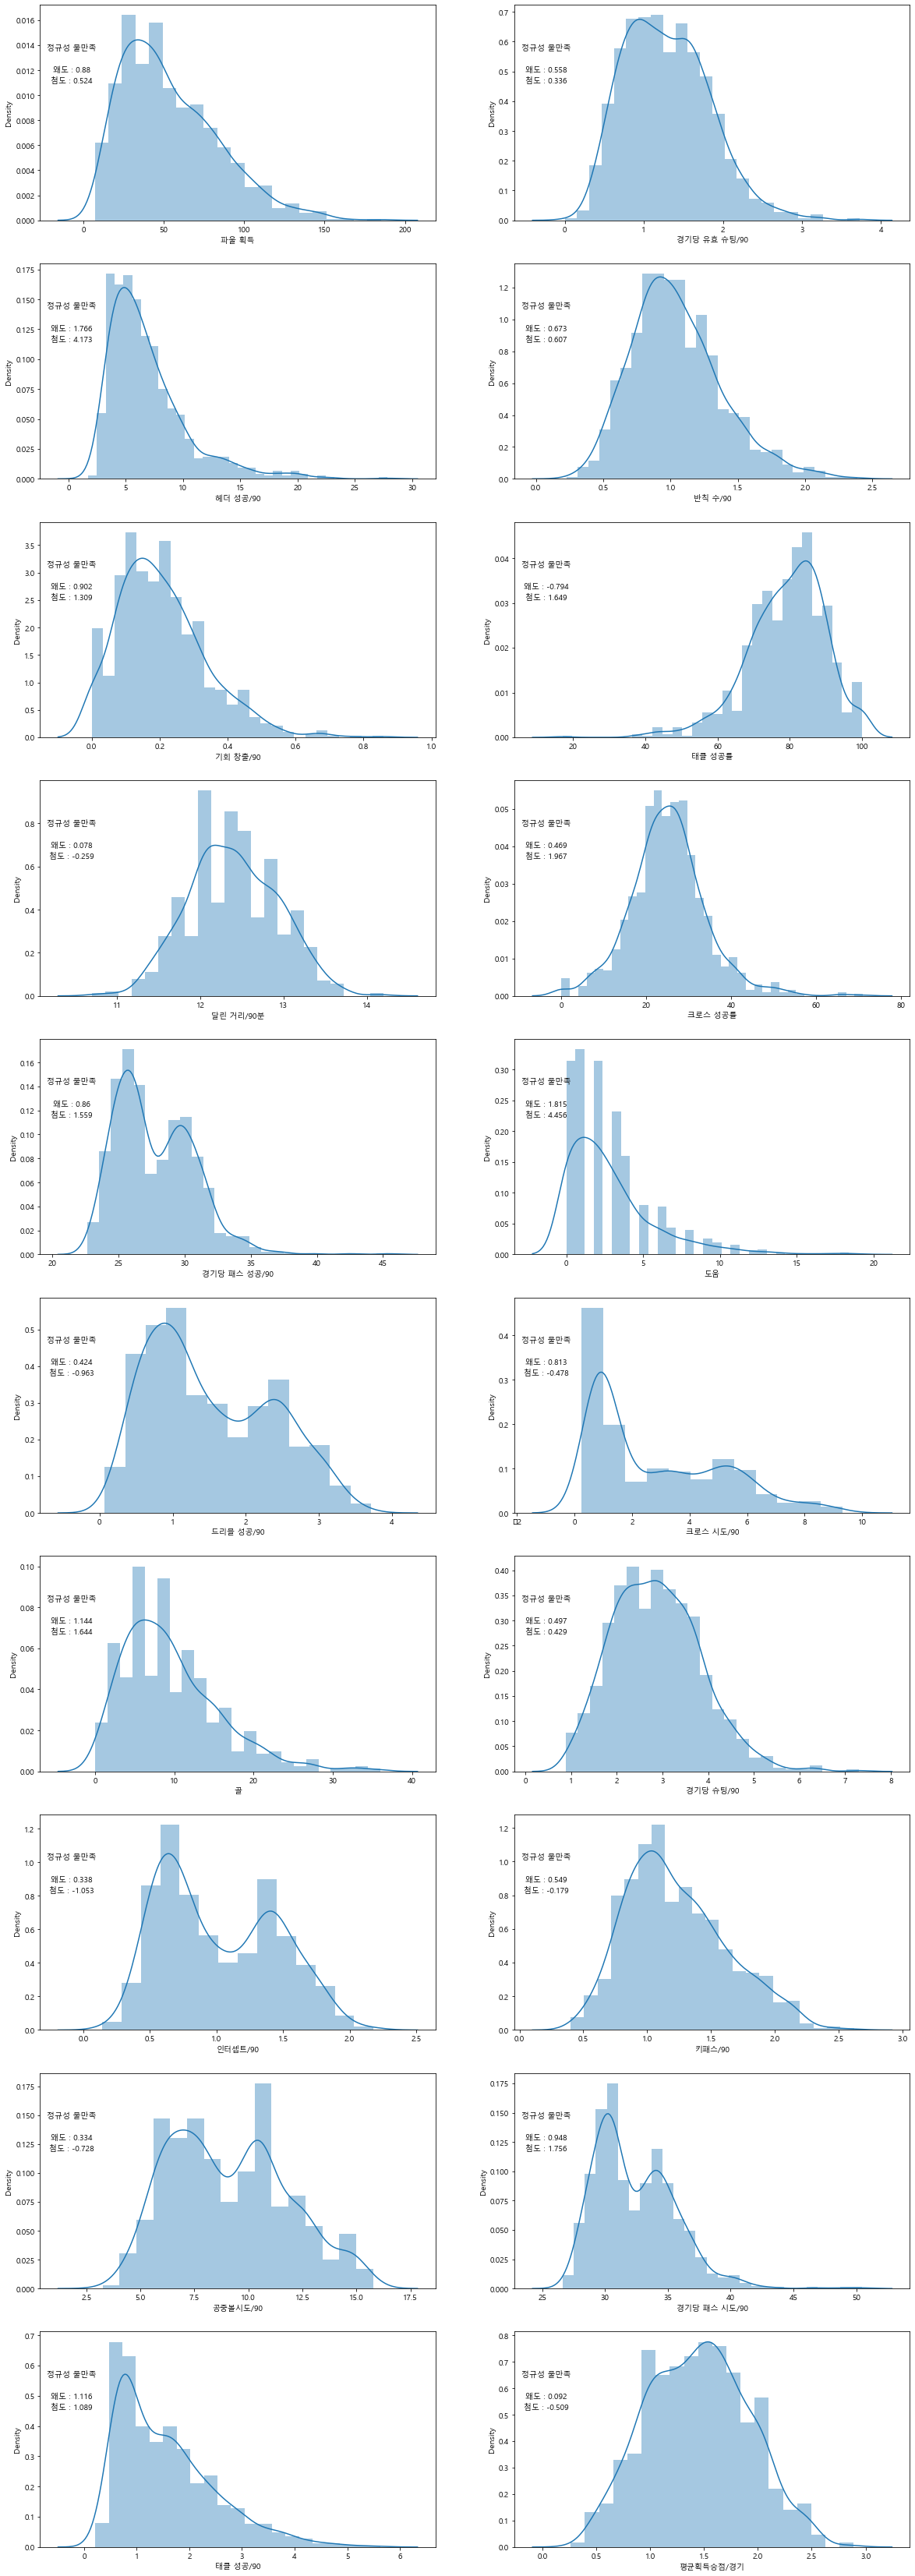

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = forward_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = forward_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

모든 변수가 정규성 불만족 -> 정규화 필요

## 이상치 탐지

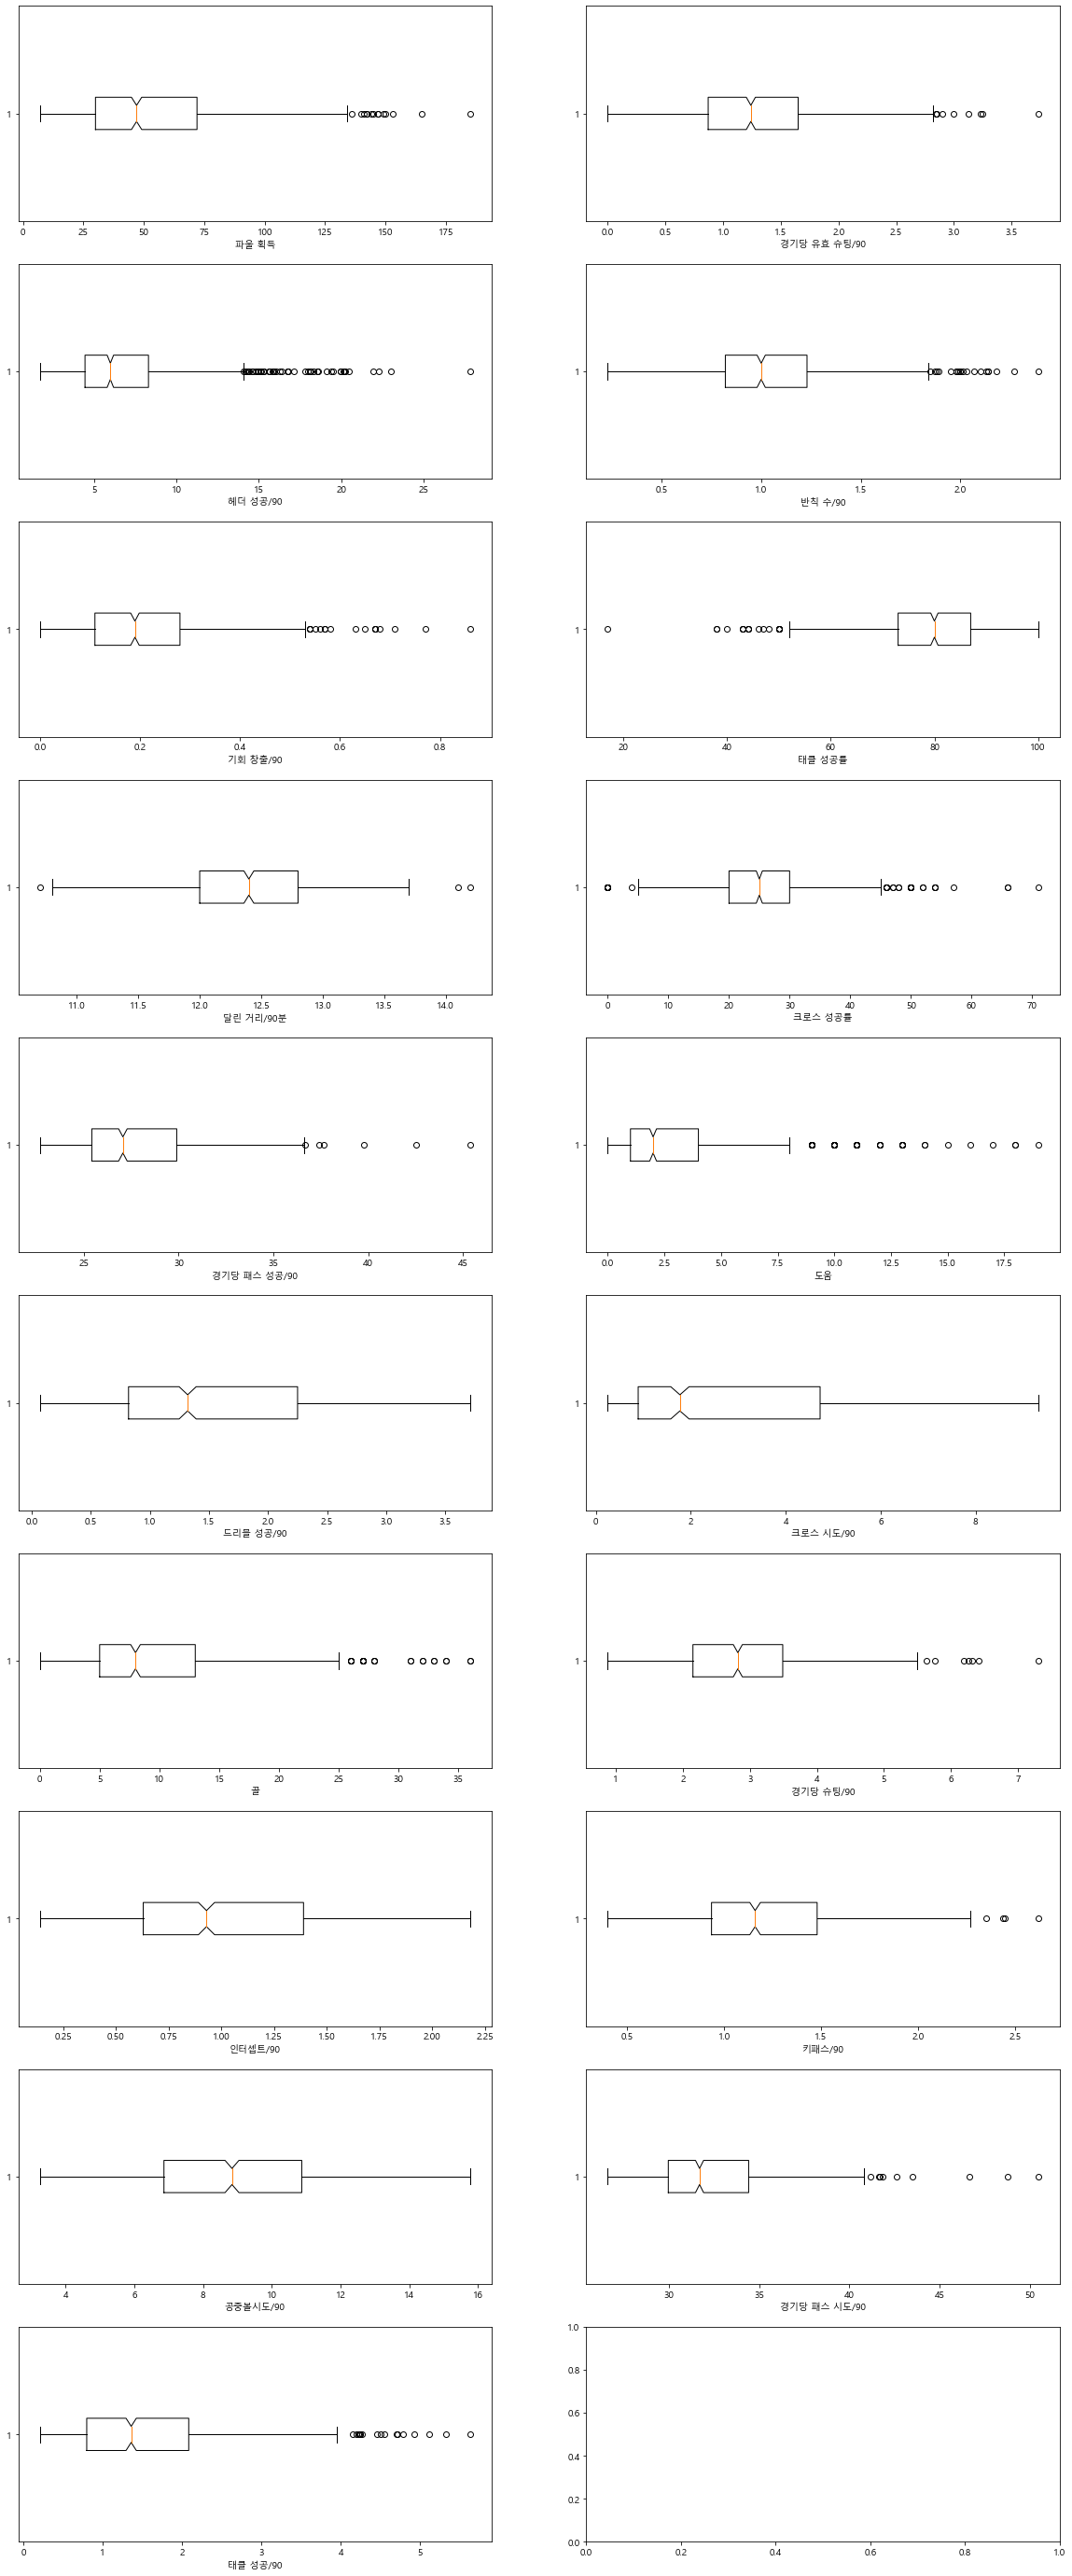

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 990개의 데이터 중 {len(total)} 개 입니다.')

파울 획득중 이상치는 25개 비율은 약 2.525% 입니다

경기당 유효 슈팅/90중 이상치는 15개 비율은 약 1.515% 입니다

헤더 성공/90중 이상치는 77개 비율은 약 7.778% 입니다

반칙 수/90중 이상치는 38개 비율은 약 3.838% 입니다

기회 창출/90중 이상치는 30개 비율은 약 3.03% 입니다

태클 성공률중 이상치는 23개 비율은 약 2.323% 입니다

달린 거리/90분중 이상치는 5개 비율은 약 0.505% 입니다

크로스 성공률중 이상치는 46개 비율은 약 4.646% 입니다

경기당 패스 성공/90중 이상치는 8개 비율은 약 0.808% 입니다

도움중 이상치는 100개 비율은 약 10.101% 입니다

드리블 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

크로스 시도/90중 이상치는 8개 비율은 약 0.808% 입니다

골중 이상치는 34개 비율은 약 3.434% 입니다

경기당 슈팅/90중 이상치는 11개 비율은 약 1.111% 입니다

인터셉트/90중 이상치는 0개 비율은 약 0.0% 입니다

키패스/90중 이상치는 26개 비율은 약 2.626% 입니다

공중볼시도/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 패스 시도/90중 이상치는 19개 비율은 약 1.919% 입니다

태클 성공/90중 이상치는 42개 비율은 약 4.242% 입니다

이상치가 있는 row의 갯수는 총 990개의 데이터 중 363 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

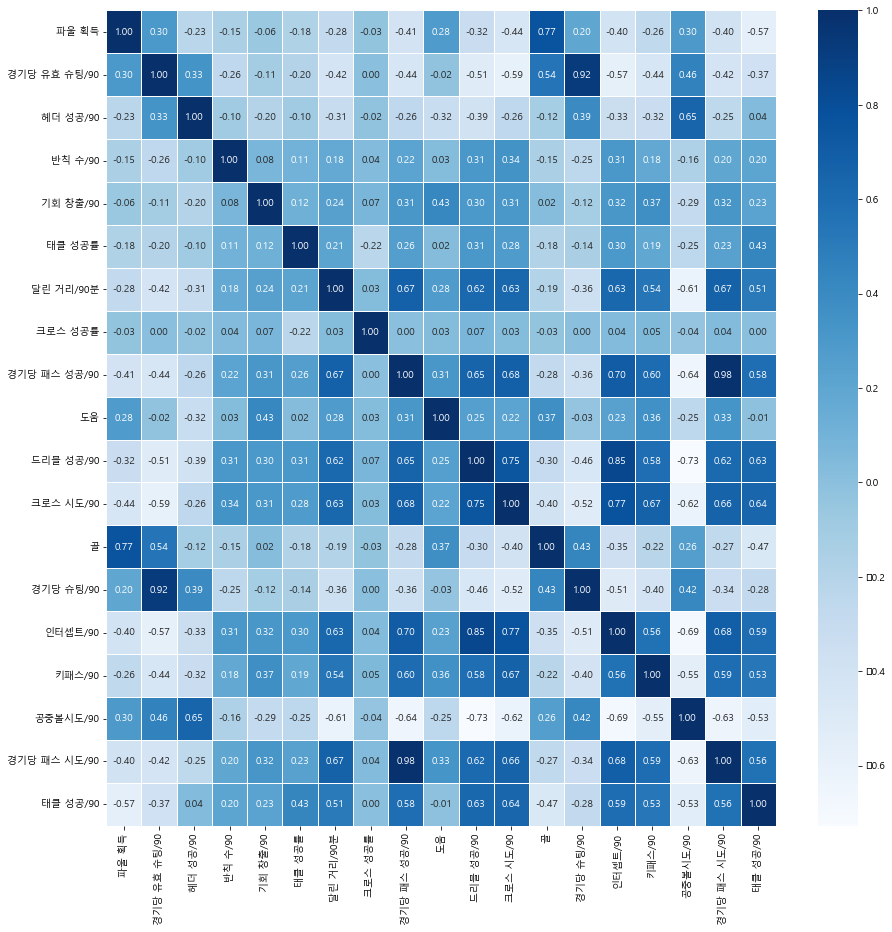

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = forward_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 종속변수 간 상관계수 , 독립변수와 상관계수

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,파울 획득,골,0.755574
1,경기당 유효 슈팅/90,경기당 슈팅/90,0.919081
2,경기당 패스 성공/90,드리블 성공/90,0.710803
3,경기당 패스 성공/90,크로스 시도/90,0.763061
4,경기당 패스 성공/90,인터셉트/90,0.740557
5,경기당 패스 성공/90,경기당 패스 시도/90,0.975738
6,드리블 성공/90,크로스 시도/90,0.767371
7,드리블 성공/90,인터셉트/90,0.838974
8,드리블 성공/90,공중볼시도/90,-0.753751
9,크로스 시도/90,인터셉트/90,0.756682


In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(forward_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])

,종속변수,독립변수,상관계수
0,파울 획득,평균획득승점/경기,0.040846
1,경기당 유효 슈팅/90,평균획득승점/경기,0.301633
2,헤더 성공/90,평균획득승점/경기,-0.101678
3,반칙 수/90,평균획득승점/경기,-0.018040
4,기회 창출/90,평균획득승점/경기,0.217395
5,태클 성공률,평균획득승점/경기,0.046058
6,달린 거리/90분,평균획득승점/경기,0.204189
7,크로스 성공률,평균획득승점/경기,0.012961
8,경기당 패스 성공/90,평균획득승점/경기,0.191469
9,도움,평균획득승점/경기,0.356967


### 다중공선성

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.724547,도움
1,4.799466,기회 창출/90
2,9.625052,크로스 시도/90
3,9.817092,크로스 성공률
4,12.474020,반칙 수/90
5,13.158411,골
6,13.796837,태클 성공/90
7,15.672334,파울 획득
8,18.684251,헤더 성공/90
9,21.396413,드리블 성공/90


# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [12]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [13]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(forward_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 도움, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [14]:
forward_df[['골','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골,1.000000,0.543104,0.433125,0.378764
경기당 유효 슈팅/90,0.543104,1.000000,0.921081,0.305433
경기당 슈팅/90,0.433125,0.921081,1.000000,0.284880
평균획득승점/경기,0.378764,0.305433,0.284880,1.000000


#### 피쳐 엔지니어링

In [15]:
# 0골인 선수 보정
forward_df['골'] = forward_df['골']+1

# Shoot Accuracy Weighted Goal
forward_df['SAWG'] = (forward_df['경기당 유효 슈팅/90'] / forward_df['경기당 슈팅/90'])*forward_df['골']

independent_value.add('SAWG')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

forward_df[['이름','SAWG']].sort_values(by='SAWG',ascending=False).head()

,이름,SAWG
259,Romelu Lukaku,20.881188
916,Romelu Lukaku,19.346801
602,Romelu Lukaku,19.249231
3,Erling Haaland,19.207650
196,Kylian Mbappé,19.119403


#### 상관계수 확인 (통과)

In [16]:
forward_df[['SAWG','평균획득승점/경기']].corr()

,SAWG,평균획득승점/경기
SAWG,1.000000,0.374903
평균획득승점/경기,0.374903,1.000000


### 도움, 경기당 패스시도, 패스성공, 키패스 

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균(0.25)보다 높은 피쳐를 만들자)

In [17]:
forward_df[['도움','경기당 패스 성공/90','경기당 패스 시도/90','키패스/90','평균획득승점/경기']].corr()

,도움,경기당 패스 성공/90,경기당 패스 시도/90,키패스/90,평균획득승점/경기
도움,1.000000,0.313180,0.325498,0.358490,0.374072
경기당 패스 성공/90,0.313180,1.000000,0.981985,0.597356,0.235791
경기당 패스 시도/90,0.325498,0.981985,1.000000,0.594686,0.242171
키패스/90,0.358490,0.597356,0.594686,1.000000,0.177811
평균획득승점/경기,0.374072,0.235791,0.242171,0.177811,1.000000


#### 피쳐 엔지니어링

In [18]:
# 0도움인 선수 보정

forward_df['도움'] = forward_df['도움']+1

# Pass Accuracy Weighted Assist And Keypass
forward_df['PAWAAK'] = (forward_df['경기당 패스 성공/90'] / forward_df['경기당 패스 시도/90'])*forward_df['도움']+forward_df['키패스/90']

independent_value.add('PAWAAK')
independent_value = independent_value - set(['도움','경기당 패스 시도/90','경기당 패스 성공/90','키패스/90'])

forward_df[['이름','PAWAAK']].sort_values(by='PAWAAK',ascending=False).head()

,이름,PAWAAK
599,Kai Havertz,19.077682
766,Gonçalo Guedes,18.282548
867,Mohamed Salah,17.483630
923,Harry Kane,17.124288
918,Gabriel Jesus,17.106808


#### 상관계수 확인 (통과)

In [19]:
forward_df[['PAWAAK','평균획득승점/경기']].corr()

,PAWAAK,평균획득승점/경기
PAWAAK,1.000000,0.377387
평균획득승점/경기,0.377387,1.000000


#### 다중 공선성 재확인

In [20]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.738566,기회 창출/90
1,6.882982,PAWAAK
2,8.019820,SAWG
3,8.441778,크로스 시도/90
4,9.381072,크로스 성공률
5,12.381688,반칙 수/90
6,12.754707,태클 성공/90
7,13.576145,파울 획득
8,16.656781,헤더 성공/90
9,20.706591,드리블 성공/90


### 태클 성공률, 태클 성공/90

#### 태클 성공률, 태클 성공/90 제거 -> 90분당 태클 시도 생성

In [21]:
forward_df['태클 시도/90'] = forward_df['태클 성공/90']/forward_df['태클 성공률']

In [22]:
forward_df[['태클 시도/90','태클 성공/90','태클 성공률','평균획득승점/경기']].corr()

,태클 시도/90,태클 성공/90,태클 성공률,평균획득승점/경기
태클 시도/90,1.000000,0.975974,0.256740,0.168233
태클 성공/90,0.975974,1.000000,0.433836,0.164341
태클 성공률,0.256740,0.433836,1.000000,0.043326
평균획득승점/경기,0.168233,0.164341,0.043326,1.000000


In [23]:
forward_df['태클'] = (forward_df['태클 성공/90'])+(forward_df['태클 시도/90']*1.4)
forward_df[['태클','평균획득승점/경기']].corr()

,태클,평균획득승점/경기
태클,1.000000,0.164463
평균획득승점/경기,0.164463,1.000000


태클 시도/90 만 넣는 것이 평균획득승점을 예측하는 것에 도움이 된다.
실제로 공격수는 상대의 빌드업시 얼마나 괴롭혀 줄 수 있는지가 핵심이지 얼마나 정확하게 태클하는 지는 크게 중요하지 않다고 생각.

In [24]:
independent_value.add('태클 시도/90')
independent_value = independent_value-set(['태클 성공률','태클 성공/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,4.715654,기회 창출/90
1,6.846964,PAWAAK
2,7.992119,SAWG
3,8.410661,크로스 시도/90
4,8.846937,크로스 성공률
5,12.376151,반칙 수/90
6,13.352817,태클 시도/90
7,13.574512,파울 획득
8,16.908166,헤더 성공/90
9,20.511120,드리블 성공/90


### 공중볼시도/90, 헤더 성공/90

#### 공중볼시도/90 헤더 성공/90 -> 피쳐 엔지니어링

In [25]:
forward_df[['공중볼시도/90','헤더 성공/90','평균획득승점/경기']].corr()

,공중볼시도/90,헤더 성공/90,평균획득승점/경기
공중볼시도/90,1.00000,0.645100,-0.266620
헤더 성공/90,0.64510,1.000000,-0.142866
평균획득승점/경기,-0.26662,-0.142866,1.000000


In [26]:
forward_df['헤더'] = (forward_df['공중볼시도/90'])+(forward_df['헤더 성공/90'])
forward_df[['헤더','평균획득승점/경기']].corr()

,헤더,평균획득승점/경기
헤더,1.000000,-0.217201
평균획득승점/경기,-0.217201,1.000000


헤더는 타깃형 스트라이커에게는 유리한 지표일 수 있으나, 그렇지 않은 공격수에게는 불이익을 얻을 수 있는 지표 선수의 체격조건을 고려할 수 없기 때문에 공중볼에 대한 피쳐는 제거하기로 결정

In [27]:
independent_value = independent_value - set(['공중볼시도/90','헤더 성공/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,4.698246,기회 창출/90
1,6.711274,PAWAAK
2,7.904236,SAWG
3,8.313527,크로스 시도/90
4,8.819566,크로스 성공률
5,10.314433,태클 시도/90
6,11.861715,파울 획득
7,11.984364,반칙 수/90
8,18.211829,드리블 성공/90
9,28.491009,인터셉트/90


### 드리블 시도

#### 종속변수와 상관계수 확인

In [28]:
forward_df[['드리블 성공/90','평균획득승점/경기']].corr()

,드리블 성공/90,평균획득승점/경기
드리블 성공/90,1.000000,0.217248
평균획득승점/경기,0.217248,1.000000


#### 독립변수 간 상관계수 확인

In [29]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,파울 획득,SAWG,0.728373
1,인터셉트/90,드리블 성공/90,0.838974
2,인터셉트/90,크로스 시도/90,0.756682
3,태클 시도/90,크로스 시도/90,0.764701
4,드리블 성공/90,크로스 시도/90,0.767371


In [30]:
forward_df[['크로스 시도/90','평균획득승점/경기']].corr()

,크로스 시도/90,평균획득승점/경기
크로스 시도/90,1.000000,0.074417
평균획득승점/경기,0.074417,1.000000


In [31]:
forward_df[['인터셉트/90','평균획득승점/경기']].corr()

,인터셉트/90,평균획득승점/경기
인터셉트/90,1.000000,0.133575
평균획득승점/경기,0.133575,1.000000


종속변수에 영향이 적은 인터셉트 제거, 크로스 시도 제거를 통해 해결

In [32]:
independent_value = independent_value - set(['크로스 시도/90','인터셉트/90'])

In [33]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,파울 획득,SAWG,0.728373


In [34]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.657459,기회 창출/90
1,6.287019,PAWAAK
2,7.651603,SAWG
3,8.759046,크로스 성공률
4,8.772946,드리블 성공/90
5,9.893748,태클 시도/90
6,11.490880,파울 획득
7,11.662962,반칙 수/90
8,35.477645,달린 거리/90분


### 파울 획득, 반칙 수

상관계수가 0.7 보다 높고 VIF가 10보다 높기 떄문에 기준에 벗어나지만 모델생성후 변수에 대해 다시 고려하기로 함

### 달린 거리/90

VIF가 너무 높기 때문에 삭제결정

In [35]:
independent_value= independent_value - set(['달린 거리/90분'])

### 최종 종속변수

In [36]:
independent_value

{'PAWAAK',
 'SAWG',
 '기회 창출/90',
 '드리블 성공/90',
 '반칙 수/90',
 '크로스 성공률',
 '태클 시도/90',
 '파울 획득'}

In [37]:
forward_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', 'SAWG', 'PAWAAK', '태클 시도/90', '태클', '헤더'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

### 독립변수,종속변수 정규화

In [38]:
# 데이터의 2/3 수준의 quantile 적용

forward_qt = QuantileTransformer(n_quantiles=500).fit(forward_df.loc[:,independent_value])
forward_df.loc[:,independent_value] = forward_qt.transform(forward_df.loc[:,independent_value])

In [39]:
independent_value

{'PAWAAK',
 'SAWG',
 '기회 창출/90',
 '드리블 성공/90',
 '반칙 수/90',
 '크로스 성공률',
 '태클 시도/90',
 '파울 획득'}

In [40]:
fx_train,fx_test,fy_train,fy_test = train_test_split(forward_df.loc[:,independent_value],forward_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [41]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.03))(inputs_layer)
hidden2 = Dense(16,activation='relu')(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
12/12 [==============================] - 1s 15ms/step - loss: 2.3297 - val_loss: 2.0813
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 1.7480 - val_loss: 1.3904
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 1.0580 - val_loss: 0.7708
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6197 - val_loss: 0.5299
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.5435 - val_loss: 0.5128
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.5180 - val_loss: 0.4899
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.4922 - val_loss: 0.4750
Epoch 8/500
12/12 [==============================] - 0s 4ms/step - loss: 0.4732 - val_loss: 0.4502
Epoch 9/500
12/12 [==============================] - 0s 5ms/step - loss: 0.4496 - val_loss: 0.4229
Epoch 10/500
12/12 [==============================] - 0s 4ms/step - loss: 0.4315 - val_loss: 0.4026
Epoch 11

12/12 [==============================] - 0s 5ms/step - loss: 0.1598 - val_loss: 0.1486
Epoch 84/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1542 - val_loss: 0.1522
Epoch 85/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1551 - val_loss: 0.1470
Epoch 86/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1523 - val_loss: 0.1466
Epoch 87/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1542 - val_loss: 0.1495
Epoch 88/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1552 - val_loss: 0.1469
Epoch 89/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1533 - val_loss: 0.1463
Epoch 90/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1530 - val_loss: 0.1550
Epoch 91/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1525 - val_loss: 0.1463
Epoch 92/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1509 - val_loss: 0.1444
Epoch 93/500


12/12 [==============================] - 0s 5ms/step - loss: 0.1355 - val_loss: 0.1354
Epoch 165/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1381 - val_loss: 0.1356
Epoch 166/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1347 - val_loss: 0.1374
Epoch 167/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1342 - val_loss: 0.1346
Epoch 168/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1370 - val_loss: 0.1357
Epoch 169/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1384 - val_loss: 0.1342
Epoch 170/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1385 - val_loss: 0.1366
Epoch 171/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1338 - val_loss: 0.1361
Epoch 172/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1355 - val_loss: 0.1367
Epoch 173/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1350 - val_loss: 0.1357
Epoc

12/12 [==============================] - 0s 6ms/step - loss: 0.1330 - val_loss: 0.1361
Epoch 246/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1328 - val_loss: 0.1380
Epoch 247/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1304 - val_loss: 0.1375
Epoch 248/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1310 - val_loss: 0.1373
Epoch 249/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1323 - val_loss: 0.1409
Epoch 250/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1318 - val_loss: 0.1383
Epoch 251/500
12/12 [==============================] - 0s 7ms/step - loss: 0.1312 - val_loss: 0.1366
Epoch 252/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1388 - val_loss: 0.1362
Epoch 253/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1311 - val_loss: 0.1391
Epoch 254/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1349 - val_loss: 0.1393
Epoc

12/12 [==============================] - 0s 5ms/step - loss: 0.1296 - val_loss: 0.1367
Epoch 327/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1317 - val_loss: 0.1369
Epoch 328/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1286 - val_loss: 0.1351
Epoch 329/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1291 - val_loss: 0.1380
Epoch 330/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.1457
Epoch 331/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1354 - val_loss: 0.1369
Epoch 332/500
12/12 [==============================] - 0s 6ms/step - loss: 0.1347 - val_loss: 0.1350
Epoch 333/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1327 - val_loss: 0.1369
Epoch 334/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1297 - val_loss: 0.1371
Epoch 335/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1282 - val_loss: 0.1392
Epoc

12/12 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.1374
Epoch 408/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1264 - val_loss: 0.1386
Epoch 409/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1284 - val_loss: 0.1396
Epoch 410/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1273 - val_loss: 0.1378
Epoch 411/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1278 - val_loss: 0.1425
Epoch 412/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1333 - val_loss: 0.1376
Epoch 413/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1267 - val_loss: 0.1367
Epoch 414/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1255 - val_loss: 0.1378
Epoch 415/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1268 - val_loss: 0.1369
Epoch 416/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1254 - val_loss: 0.1436
Epoc

12/12 [==============================] - 0s 5ms/step - loss: 0.1288 - val_loss: 0.1365
Epoch 489/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1237 - val_loss: 0.1354
Epoch 490/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1253 - val_loss: 0.1395
Epoch 491/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1271 - val_loss: 0.1360
Epoch 492/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1250 - val_loss: 0.1446
Epoch 493/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1316 - val_loss: 0.1365
Epoch 494/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1276 - val_loss: 0.1395
Epoch 495/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1244 - val_loss: 0.1388
Epoch 496/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1254 - val_loss: 0.1426
Epoch 497/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1275 - val_loss: 0.1466
Epoc

0.29254079961776736

In [42]:
with open('./models/forward_qt.pickle','wb') as f:
    pickle.dump(forward_qt,f)
model.save('./models/forward_nn.h5')

# 모델검정

In [43]:
forward_df['predict'] = model.predict(forward_df.loc[:,independent_value])

In [44]:
residual = forward_df['평균획득승점/경기'] - forward_df['predict']

## 선형성 검정

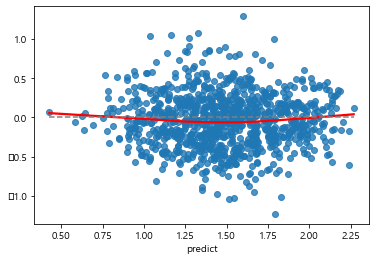

In [45]:
sns.regplot(forward_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([forward_df['predict'].values.min(), forward_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [46]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9964562654495239, pvalue=0.027244599536061287)

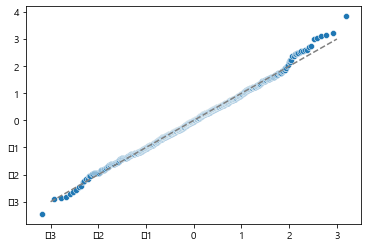

In [47]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

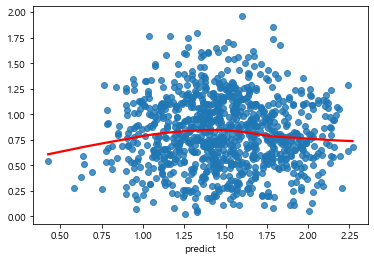

In [48]:
sns.regplot(forward_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [49]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['predict'])

LeveneResult(statistic=138.99415998590595, pvalue=4.924375040658179e-31)